# 📝 Finding Optimal State Space

## Description:

This section defines the neural architecture search (NAS) state space, which determines the range of possible sub-network configurations that the search algorithm can explore. Following the MCUNet methodology, we tailor the state space to be hardware-efficient by varying a small set of critical hyperparameters that influence both model size and performance.

For this demonstration, we define the following discrete search spaces:

    Image resolutions: RESOLUTIONS = [32, 64, 96, 128]

    Base widths (channels): WIDTHS = [16, 32, 48, 64]

In addition to resolution and width, each model configuration is parameterized by:

    'starting_kernel': [3, 5, 7, 9]
    'depth_0': [1, 2, 3, 4]
    'depth_1': [1, 2, 3, 4]
    'kernel_0': [3, 5, 7, 9]
    'kernel_1': [3, 5, 7, 9]

This leads to a total of:

    Per (resolution, width) → 1024 models

    Across all (resolution, width) → 16,384 models

To begin the search, we randomly sample 200 models from this space. These sampled models serve as the initial population for further evaluation and evolutionary optimization.

## 🛠️ For Each Sampled Model:

1. **Constraint Check:**
We check if the model meets deployment constraints (e.g., fits within the allowed TFLite flash size budget). In MCUNet, this is done using TinyEngine to check SRAM/Flash usage.

2. **FLOPs Calculation:**
We calculate the floating point operations (FLOPs) for each valid model as a proxy for compute efficiency.

## 📊 Output Metric: Average FLOPs per State Space

For each (resolution, width) state space, we compute the average FLOPs of valid models. This metric helps evaluate how efficient each state space is under hardware constraints.

In [16]:
# Define Search Space:
RESOLUTIONS = [32, 64, 96, 128]
WIDTHS = [16, 32, 48, 64]
DEPTHS = [1, 2, 3, 4]
KERNEL_SIZES = [3, 5, 7, 9]
NUMBER_OF_MODELS_TO_CHECK = 200

# 1. Imports and Util Functions

In [17]:
import os

# Suppress TensorFlow C++ backend logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import contextlib
import sys

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

@contextlib.contextmanager
def suppress_os_stderr():
    # Flush Python buffers
    sys.stderr.flush()
    # Save original stderr file descriptor
    old_stderr_fd = os.dup(2)
    # Redirect stderr to /dev/null
    devnull_fd = os.open(os.devnull, os.O_WRONLY)
    os.dup2(devnull_fd, 2)
    os.close(devnull_fd)
    try:
        yield
    finally:
        # Restore original stderr
        os.dup2(old_stderr_fd, 2)
        os.close(old_stderr_fd)

# 2. Core Functions

Functions:
1. build_model_in_ss(resolution=128, width=64, num_classes=10)
2. calculate_flop(model, input_shape)
3. convert_to_tflite(model)

In [18]:
# 1. Function: build_model_in_ss
def build_model_in_ss(resolution=128, width=64, num_classes=3):
    """
    Builds a lightweight CNN model within a specified state space configuration.

    This function generates a convolutional neural network architecture based on a given
    input resolution and channel width. The network structure includes:

    - An initial convolutional layer with a randomly selected kernel size from KERNEL_SIZES,
      followed by batch normalization, ReLU activation, and max pooling.
    - Two repeated convolutional blocks. Each block:
        - Has a randomly chosen depth (number of Conv2D-BN-ReLU layers) from DEPTHS.
        - Uses a randomly selected kernel size from KERNEL_SIZES for all convolutions in that block.
        - Ends with a max pooling layer to reduce spatial resolution.
    - A final classification head consisting of a flattening layer and a fully connected
      softmax layer for classification.

    This model structure is used during the random search over the state space, and its
    architectural choices allow exploration of different computation and memory tradeoffs.
    """
    input_shape = (resolution, resolution, 3)
    model = models.Sequential()
    model.add(layers.InputLayer(shape=input_shape))

    # Initial Convolution
    kernel_size = random.choice(KERNEL_SIZES)
    model.add(layers.Conv2D(width, kernel_size=(kernel_size, kernel_size), padding='same'))
    model.add(layers.BatchNormalization(name='bn1'))
    model.add(layers.ReLU(name='act1'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool1'))
    # print(f"Initial Conv Layer: {width} filters, kernel size {kernel_size}")

    # Repeated blocks
    for i in range(2):
        depth = random.choice(DEPTHS)
        kernel_size = random.choice(KERNEL_SIZES)
        for d in range(depth):
            model.add(layers.Conv2D(width, kernel_size, padding='same'))
            model.add(layers.BatchNormalization())
            model.add(layers.ReLU())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        # print(f"Block {i+1}: {depth} layers, kernel size {kernel_size}")

    # Classification head
    model.add(layers.Flatten(name="flatten"))
    model.add(layers.Dense(num_classes, activation='softmax', name="output"))

    return model

# 2. Function: calculate_flop
def calculate_flop(model, input_shape):
    """
    Estimates the total number of floating point operations (FLOPs) for a given Keras model.

    This function simulates a forward pass using a dummy input tensor and traverses each layer
    in the model to calculate its associated FLOPs. It currently supports Conv2D and Dense layers:

    - For Conv2D layers:
        FLOPs = 2 * H_out * W_out * C_in * K_h * K_w * C_out
        where H_out and W_out are the output height and width,
        C_in is the number of input channels, K_h and K_w are the kernel dimensions,
        and C_out is the number of filters.

    - For Dense layers:
        FLOPs = 2 * Input_Dim * Output_Dim

    Other layers (e.g., BatchNormalization, ReLU, MaxPooling, Flatten) are ignored or passed
    through without contributing to the FLOPs count.
    """

    total_flops = 0
    dummy_input = tf.random.normal((1, *input_shape))  # batch size 1
    x = dummy_input

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            # Input shape: (batch, height, width, channels)
            _, h_in, w_in, c_in = x.shape
            kh, kw = layer.kernel_size
            c_out = layer.filters

            # Output dimensions (same padding, stride=1)
            h_out, w_out = h_in, w_in

            # FLOPs = 2 * H_out * W_out * Cin * Kh * Kw * Cout
            flops = 2 * int(h_out) * int(w_out) * int(c_in) * kh * kw * c_out
            total_flops += flops

            # Update shape
            x = layer(x)

        elif isinstance(layer, tf.keras.layers.Dense):
            input_dim = np.prod(x.shape[1:])
            output_dim = layer.units

            # FLOPs = 2 * input * output
            flops = 2 * int(input_dim) * int(output_dim)
            total_flops += flops
            x = layer(x)  # for shape tracking

        else:
            try:
                x = layer(x)  # for shape tracking
            except:
                pass  # skip non-parametric layers like Flatten, ReLU, etc.

    return total_flops

# 3. Function: convert_to_tflite
def convert_to_tflite(model):
    """
    Converts a Keras model to a TensorFlow Lite model.

    This function uses the TensorFlow Lite converter
    """

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    with suppress_os_stderr():
        tflite_model = converter.convert()

    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    return tflite_model, interpreter

# 4. Function: run_search
def run_search(resolution=128, width=64, num_classes=3):
    """
    This function performs a random model search within a given state space configuration
    (resolution and width) to evaluate models based on their flash size and floating point
    operations (FLOPs).

    Steps:
    1. **Model Generation**: A random CNN model is created using `build_model_in_ss`
       with the specified resolution and width.
    2. **TFLite Conversion**: The generated model is converted to TensorFlow Lite (TFLite) format
       to calculate its flash size.
    3. **Flash Size Check**: The TFLite model is accepted if its flash size is below 1MB.
    4. **FLOP Estimation**: For each accepted model, the number of floating point operations (FLOPs)
       is estimated and converted to millions of FLOPs (MFLOPs).
    5. **Metrics Calculation**: The average FLOPs of the accepted models are calculated and printed.
    """

    flop_dict = {}
    print("============================")
    print(f"⚙️ Generating {NUMBER_OF_MODELS_TO_CHECK} models per state")
    print("============================")
    r = resolution
    w = width
    flops_total = 0
    accepted_models = 0
    for i in tqdm(range(NUMBER_OF_MODELS_TO_CHECK), desc=f"Generating models for resolution {r} and width {w}"):
        model = build_model_in_ss(resolution=r, width=w, num_classes=num_classes)

        # THIS IS SPECIFIC FOR FLASH SIZE CONSTRAINT AND TFLITE CONVERTER
        # =================================================================
        with suppress_output():
            tflite_model, interpreter = convert_to_tflite(model)
        flash_size = len(tflite_model)
        # check if flash size are below 500KB
        if flash_size < (1e6/2):
            flop_estimate = calculate_flop(model, input_shape=(r, r, 3))
            accepted_models += 1
            flops = round(flop_estimate / 1e6)  # Convert to millions of FLOPs
            flops_total += flops
        else:
            continue
         # =================================================================
    print(f"🟢 Accepted models: {accepted_models}")
    flop_dict[(r, w)] = flops_total / accepted_models if accepted_models > 0 else 0

    for key, value in flop_dict.items():
        print(f"🟢 Resolution: {key[0]}, Width: {key[1]} -> Average FLOPs: {value} MFLOPs")

# 3. Main Search

In [13]:
# run_search for the entire state space (WILL TAKE A LONG TIME!)
for r in RESOLUTIONS:
    for w in WIDTHS:
        run_search(resolution=r, width=w, num_classes=3)

NameError: name 'RESOLUTIONS' is not defined

We manually run the run_search for now for each state space to prevent crashes. If you wish to iterate over the entire resolution, all you need to do is run the code above

In [19]:
run_search(resolution=32, width=16, num_classes=3)
run_search(resolution=32, width=32, num_classes=3)
run_search(resolution=32, width=48, num_classes=3)
run_search(resolution=32, width=64, num_classes=3)

⚙️ Generating 200 models per state


Generating models for resolution 32 and width 16: 100%|██████████| 200/200 [08:13<00:00,  2.47s/it]


🟢 Accepted models: 200
🟢 Resolution: 32, Width: 16 -> Average FLOPs: 21.21 MFLOPs
⚙️ Generating 200 models per state


Generating models for resolution 32 and width 32: 100%|██████████| 200/200 [08:10<00:00,  2.45s/it]


🟢 Accepted models: 191
🟢 Resolution: 32, Width: 32 -> Average FLOPs: 74.0261780104712 MFLOPs
⚙️ Generating 200 models per state


Generating models for resolution 32 and width 48: 100%|██████████| 200/200 [08:22<00:00,  2.51s/it]


🟢 Accepted models: 118
🟢 Resolution: 32, Width: 48 -> Average FLOPs: 101.14406779661017 MFLOPs
⚙️ Generating 200 models per state


Generating models for resolution 32 and width 64: 100%|██████████| 200/200 [08:39<00:00,  2.60s/it]

🟢 Accepted models: 55
🟢 Resolution: 32, Width: 64 -> Average FLOPs: 116.61818181818182 MFLOPs


In [20]:
run_search(resolution=64, width=16, num_classes=3)
run_search(resolution=64, width=32, num_classes=3)
run_search(resolution=64, width=48, num_classes=3)
run_search(resolution=64, width=64, num_classes=3)

⚙️ Generating 200 models per state


Generating models for resolution 64 and width 16: 100%|██████████| 200/200 [07:47<00:00,  2.34s/it]


🟢 Accepted models: 200
🟢 Resolution: 64, Width: 16 -> Average FLOPs: 79.98 MFLOPs
⚙️ Generating 200 models per state


Generating models for resolution 64 and width 32: 100%|██████████| 200/200 [08:10<00:00,  2.45s/it]


🟢 Accepted models: 192
🟢 Resolution: 64, Width: 32 -> Average FLOPs: 298.5208333333333 MFLOPs
⚙️ Generating 200 models per state


Generating models for resolution 64 and width 48: 100%|██████████| 200/200 [08:20<00:00,  2.50s/it]


🟢 Accepted models: 116
🟢 Resolution: 64, Width: 48 -> Average FLOPs: 396.4051724137931 MFLOPs
⚙️ Generating 200 models per state


Generating models for resolution 64 and width 64: 100%|██████████| 200/200 [08:53<00:00,  2.67s/it]

🟢 Accepted models: 55
🟢 Resolution: 64, Width: 64 -> Average FLOPs: 449.5272727272727 MFLOPs


In [21]:
run_search(resolution=96, width=16, num_classes=3)
run_search(resolution=96, width=32, num_classes=3)
run_search(resolution=96, width=48, num_classes=3)
run_search(resolution=96, width=64, num_classes=3)

⚙️ Generating 200 models per state


Generating models for resolution 96 and width 16: 100%|██████████| 200/200 [07:42<00:00,  2.31s/it]


🟢 Accepted models: 200
🟢 Resolution: 96, Width: 16 -> Average FLOPs: 180.23 MFLOPs
⚙️ Generating 200 models per state


Generating models for resolution 96 and width 32: 100%|██████████| 200/200 [08:06<00:00,  2.43s/it]


🟢 Accepted models: 191
🟢 Resolution: 96, Width: 32 -> Average FLOPs: 653.5340314136125 MFLOPs
⚙️ Generating 200 models per state


Generating models for resolution 96 and width 48: 100%|██████████| 200/200 [08:37<00:00,  2.59s/it]


🟢 Accepted models: 109
🟢 Resolution: 96, Width: 48 -> Average FLOPs: 910.2018348623853 MFLOPs
⚙️ Generating 200 models per state


Generating models for resolution 96 and width 64: 100%|██████████| 200/200 [08:42<00:00,  2.61s/it]

🟢 Accepted models: 65
🟢 Resolution: 96, Width: 64 -> Average FLOPs: 997.7076923076924 MFLOPs


In [22]:
run_search(resolution=128, width=16, num_classes=3)
run_search(resolution=128, width=32, num_classes=3)
run_search(resolution=128, width=48, num_classes=3)
run_search(resolution=128, width=64, num_classes=3)

⚙️ Generating 200 models per state


Generating models for resolution 128 and width 16: 100%|██████████| 200/200 [08:09<00:00,  2.45s/it]


🟢 Accepted models: 200
🟢 Resolution: 128, Width: 16 -> Average FLOPs: 328.405 MFLOPs
⚙️ Generating 200 models per state


Generating models for resolution 128 and width 32: 100%|██████████| 200/200 [08:26<00:00,  2.53s/it]


🟢 Accepted models: 189
🟢 Resolution: 128, Width: 32 -> Average FLOPs: 1086.8624338624338 MFLOPs
⚙️ Generating 200 models per state


Generating models for resolution 128 and width 48: 100%|██████████| 200/200 [08:37<00:00,  2.59s/it]


🟢 Accepted models: 101
🟢 Resolution: 128, Width: 48 -> Average FLOPs: 1538.5742574257426 MFLOPs
⚙️ Generating 200 models per state


Generating models for resolution 128 and width 64: 100%|██████████| 200/200 [08:45<00:00,  2.63s/it]

🟢 Accepted models: 61
🟢 Resolution: 128, Width: 64 -> Average FLOPs: 1702.688524590164 MFLOPs


# 📌 Summary

## State Space Search Result:

The best performing state space is resolution 128 and width 64: <br>
🟢 Accepted models: 61 <br>
🟢 Resolution: 128, Width: 64 -> Average FLOPs: 1702.688524590164 MFLOPs

# 📝 NAS w/ Weight Sharing and Evolution Algorithm

## Description:

This section implements a neural architecture search (NAS) strategy using an evolutionary algorithm combined with weight sharing. Instead of training each candidate architecture from scratch, we reuse weights across different configurations to drastically reduce search time and computational cost. The evolutionary process maintains a population of architecture candidates, selects top-performing individuals based on validation accuracy, and generates new candidates through crossover and mutation. This hybrid approach leverages the exploration capability of evolution and the efficiency of weight sharing, allowing for scalable and hardware-aware NAS.

# 1. Imports and Dataset Loader

In [1]:
import contextlib
import sys
import os

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

@contextlib.contextmanager
def suppress_os_stderr():
    # Flush Python buffers
    sys.stderr.flush()
    # Save original stderr file descriptor
    old_stderr_fd = os.dup(2)
    # Redirect stderr to /dev/null
    devnull_fd = os.open(os.devnull, os.O_WRONLY)
    os.dup2(devnull_fd, 2)
    os.close(devnull_fd)
    try:
        yield
    finally:
        # Restore original stderr
        os.dup2(old_stderr_fd, 2)
        os.close(old_stderr_fd)

In [2]:
import tensorflow as tf
from keras import layers, models
import numpy as np
import tensorflow_datasets as tfds
from re import search
import random
import copy
from tqdm import tqdm

## 🛠️ Global Variable Definition:

For this demonstration, we define the following settings:


    # Best settings according to state space optimiation
    RESOLUTION = 128

    WIDTH = 64

    NUM_CLASSES = 3

    BATCH_SIZE = 128

and also:

    # Evolution search related params
    KERNEL = [3, 5, 7, 9]
    DEPTH = [1, 2, 3, 4]
    POP_SIZE = 10
    POP_ITERATIONS = 10
    search_space = {
        'starting_kernel': KERNEL,
        'depth_0': DEPTH,
        'depth_1': DEPTH,
        'kernel_0': KERNEL,
        'kernel_1': KERNEL,
    }

In [21]:
RESOLUTION = 128
WIDTH = 64
NUM_CLASSES = 3
BATCH_SIZE = 128

# Evolution Search Related Param
KERNEL = [3, 5, 7, 9]
DEPTH = [1, 2, 3, 4]
POP_SIZE = 10
POP_ITERATIONS = 10
search_space = {
    'starting_kernel': KERNEL,
    'depth_0': DEPTH,
    'depth_1': DEPTH,
    'kernel_0': KERNEL,
    'kernel_1': KERNEL,
}

In [22]:
# 1. Load dataset with 80% train, 20% validation, and full test split
(ds_train, ds_val, ds_test) = tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]', 'train[80%:]', 'test'],
    as_supervised=True,
    with_info=False
)

# 2. Preprocessing function
def preprocess(x, y):
    x = tf.image.resize(x, [IMG_SIZE, IMG_SIZE])
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.one_hot(y, NUM_CLASSES)
    return x, y

# 2. Define image size and preprocessing
IMG_SIZE = RESOLUTION

# 3. Apply preprocessing and batching
train_ds = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 2. Core Functions

**Functions:**<br>
1. build_model_sn(resolution=128, width=64, num_classes=3)
2. slice_kernel(weight, target_kernel_size)
3. sample_subnetwork(super_model, config, resolution=128, width=64, num_classes=3)
<br><br> *Sub-network fitness evaluation functions* <br><br>
4. convert_to_tflite(model)
5. calibrate_batchnorm(model, dataset, num_batches)
<br><br> *Evolution algorithm functions* <br><br>
6. crossover(parent1, parent2)
7. mutate(config, mutation_prob=0.5, search_space=None)
8. evolve_one_generation(population, search_space, mutation_prob=0.5)
<br><br> *Final tflite evaluation* <br><br>
9. evaluate_tflite_model(interpreter, test_ds)

In [5]:
# 1. Function: build_model_sn
def build_model_sn(resolution=128, width=64, num_classes=3):
    """
    Builds the Super-Network (SN) model, which serves as the full architecture
    containing all possible sub-network configurations.

    This model is the over-parameterized backbone from which smaller sub-networks
    (SS) are sampled during architecture search. It includes repeated convolutional
    blocks with consistent kernel sizes and width across layers. The design ensures
    that any smaller model sampled from the search space is a valid subgraph of this
    super-network.
    """

    input_shape = (resolution, resolution, 3)
    model = models.Sequential()
    model.add(layers.InputLayer(shape=input_shape, name='input_layer'))

    # Initial Convolution
    kernel_size = 9
    model.add(layers.Conv2D(width, kernel_size=(kernel_size, kernel_size), padding='same', name='conv0'))
    model.add(layers.BatchNormalization(name='bn0'))
    model.add(layers.ReLU(name='act0'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool0'))
    # print(f"Initial Conv Layer: {width} filters, kernel size {kernel_size}")

    # Repeated blocks
    for i in range(2):
        depth = 4
        kernel_size = 9
        for d in range(depth):
            model.add(layers.Conv2D(width, kernel_size, padding='same', name=f'block{i}_conv{d}'))
            model.add(layers.BatchNormalization())
            model.add(layers.ReLU())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        # print(f"Block {i+1}: {depth} layers, kernel size {kernel_size}")

    # Classification head
    model.add(layers.Flatten(name="flatten"))
    model.add(layers.Dense(num_classes, activation='softmax', name="output"))

    return model

# 2. Function: slice_kernel
def slice_kernel(weight, target_kernel_size):
    """
    Crop weights of kernel to target kernel size.
    """
    original_kernel_size = weight.shape[0]
    center = original_kernel_size // 2
    half = target_kernel_size // 2
    start = center - half
    end = center + half + 1
    return weight[start:end, start:end, :, :]

# 3. Function: sample_subnetwork
def sample_subnetwork(super_model, config, resolution=128, width=64, num_classes=3):
    """
    Samples a sub-network from a given Super-Network based on a specified configuration.

    This function constructs a smaller architecture that inherits weights from the
    Super-Network (`super_model`). The sampled sub-network mimics a specific architecture
    defined by `config`, typically varying in kernel sizes and depth per block. It is
    useful for weight-sharing neural architecture search (NAS), where models are
    efficiently evaluated without training from scratch.

    Steps:
    1. **Input Layer**: Initializes the input layer with the given resolution.
    2. **Initial Convolution**:
       - Extracts the weights from the `conv0` layer of the super-model.
       - Slices the kernel based on `config['starting_kernel']`.
       - Reconstructs the Conv2D layer with the sliced weights.
    3. **Repeated Blocks**:
       - For each of the two blocks:
         - Uses the configured depth (`depth_i`) and kernel size (`kernel_i`).
         - Extracts and slices weights from the corresponding super-model layers.
         - Builds and adds Conv2D → BN → ReLU layers accordingly.
         - Applies max pooling after each block.
    4. **Classification Head**:
       - Flattens the feature maps and adds a Dense layer with softmax activation
         to produce class probabilities.
    """

    input_shape = (resolution, resolution, 3)
    model = models.Sequential()
    model.add(layers.InputLayer(shape=input_shape, name='input_layer'))

    # 1. First conv
    conv0 = super_model.get_layer("conv0")  # Get the layer from the super model
    kernel_size = config['starting_kernel']

    # Extract kernel weights from the conv0 layer of the super_model
    kernel_weights = conv0.get_weights()[0]  # Shape should be (height, width, input_channels, output_channels)
    bias_weights = conv0.get_weights()[1]  # Shape should be (output_channels,)

    # You can slice the kernel based on your kernel size, if required
    sliced_kernel = slice_kernel(kernel_weights, kernel_size)  # Define this function based on your needs

    # Create a Conv2D layer with the desired kernel and bias weights
    conv_layer = layers.Conv2D(width, kernel_size=(kernel_size, kernel_size), padding='same', name='conv0')

    # Set the new weights (kernel and bias) for the Conv2D layer
    conv_layer.build((1,32,32,3))
    conv_layer.set_weights([sliced_kernel, bias_weights])

    # Add this new Conv2D layer to the model
    model.add(conv_layer)
    model.add(layers.BatchNormalization(name='bn0'))
    model.add(layers.ReLU(name='act0'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool0'))

    current_shape = (resolution/2, resolution/2, width)

    # 2. Repeated Blocks
    for i in range(2):
        depth = config[f'depth_{i}']
        kernel_size = config[f'kernel_{i}']
        for d in range(depth):
            conv = super_model.get_layer(f'block{i}_conv{d}')
            kernel_weights = conv.get_weights()[0]
            bias_weights = conv.get_weights()[1]
            sliced_kernel = slice_kernel(kernel_weights, kernel_size)
            conv_layer = layers.Conv2D(width, kernel_size, padding='same', name=f'block{i}_conv{d}')
            conv_layer.build((1,) + current_shape)
            conv_layer.set_weights([sliced_kernel, bias_weights])
            model.add(conv_layer)
            model.add(layers.BatchNormalization())
            model.add(layers.ReLU())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        current_shape = (current_shape[0]/2, current_shape[1]/2, width)

    # 3. Classification head
    model.add(layers.Flatten(name="flatten"))
    model.add(layers.Dense(num_classes, activation='softmax', name="output"))

    return model

# 4. Function: convert_to_tflite
def convert_to_tflite(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    with suppress_os_stderr():
        tflite_model = converter.convert()

    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    return tflite_model, interpreter

# 5. Function: calibrate_batchnorm
def calibrate_batchnorm(model, dataset, num_batches):
    """Runs `num_batches` of data through the model to update BN stats."""
    for i, (x, _) in enumerate(dataset):
        if i >= num_batches:
            break
        # Run in training mode so BN updates its moving mean/variance
        model(x, training=True)
    print("✅ Calibration done.")

# 6. Function: crossover
def crossover(parent1, parent2):
    """Cross two configs to create a child config."""
    child = {}
    for key in parent1:
        child[key] = random.choice([parent1[key], parent2[key]])
    return child

# 7. Function: mutate
def mutate(config, mutation_prob=0.5, search_space=None):
    """Mutate a config with given probability."""
    new_config = copy.deepcopy(config)
    for key in config:
        if random.random() < mutation_prob:
            new_config[key] = random.choice(search_space[key])
    return new_config

# 8. Function: evolve_one_generation
def evolve_one_generation(population, search_space, model, val_ds,
                          resolution=128, width=64, num_classes=3, mutation_prob=0.5):
    """
    Evolve population for one iteration.

    Args:
        population: List of (config, fitness) tuples.
        search_space: Dict of key -> list of possible values.
        mutation_prob: Float, mutation probability per parameter.

    Returns:
        new_population: List of 10 (config, fitness=None) tuples.
    """
    def evaluate_and_add(config, target_list):
        subnetwork = sample_subnetwork(model, config, resolution=resolution, width=width, num_classes=num_classes)

        # THIS IS SPECIFIC FOR FLASH SIZE CONSTRAINT AND TFLITE CONVERTER
        # =================================================================

        with suppress_output():
            tflite_model, interpreter = convert_to_tflite(subnetwork)
        flash_size = len(tflite_model)

        if flash_size < (1e6 / 2):
            calibrate_batchnorm(subnetwork, val_ds, num_batches=128)
            subnetwork.compile(
                optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            history = subnetwork.fit(val_ds, epochs=5, verbose=0)
            fitness = history.history['accuracy'][-1]
            print(f"🦠 Added to population: ")
            print(f"    Config: {config}, Fitness: {fitness}")
            target_list.append((config, fitness))
            return True
        # =================================================================
        return False


    # Step 1: Keep top 20%
    population.sort(key=lambda x: x[1], reverse=True)  # Sort by fitness
    top_candidate = [cfg for cfg, _ in population[:(len(population)//5)]]

    new_population = []

    # Step 2: Generate crossover children until 5 accepted
    crossover_children = []
    while len(crossover_children) < len(population)//2:
        p1, p2 = random.sample(top_candidate, 2)
        child = crossover(p1, p2)
        evaluate_and_add(child, crossover_children)

    # Step 3: Generate mutated children until 5 accepted
    mutated_children = []
    while len(mutated_children) < len(population)//2:
        parent = random.choice(top_candidate)
        mutated = mutate(parent, mutation_prob, search_space)
        evaluate_and_add(mutated, mutated_children)

    # Combine all to new generation
    new_population += crossover_children + mutated_children
    return new_population

# 9. Function: evaluate_tflite_model
def evaluate_tflite_model(interpreter, test_ds):
    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_index = input_details[0]['index']
    output_index = output_details[0]['index']

    correct = 0
    total = 0

    for x_batch, y_batch in test_ds:
        x_batch_np = x_batch.numpy()
        y_true = tf.argmax(y_batch, axis=1).numpy()

        for i in range(x_batch_np.shape[0]):
            input_tensor = np.expand_dims(x_batch_np[i], axis=0).astype(input_details[0]['dtype'])
            interpreter.set_tensor(input_index, input_tensor)
            interpreter.invoke()
            output = interpreter.get_tensor(output_index)
            y_pred = np.argmax(output)

            if y_pred == y_true[i]:
                correct += 1
            total += 1

    accuracy = correct / total
    print(f"TFLite Quantized Model Accuracy: {accuracy:.4f}")
    return accuracy

# 3. Main Code

## 🏋️‍♂️ Train a super-network

In [5]:
model = build_model_sn(resolution=RESOLUTION, width=WIDTH, num_classes=NUM_CLASSES)
model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

# save the model as supernetwork
model.save('supernetwork.keras')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv0 (Conv2D)                  │ (None, 128, 128, 64)   │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 128, 128, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act0 (ReLU)                     │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool0 (MaxPooling2D)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block0_conv0 (Conv2D)           │ (None, 64, 64, 64)     │       331,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block0_conv1 (Conv2D)           │ (None, 64, 64, 64)     │       331,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block0_conv2 (Conv2D)           │ (None, 64, 64, 64)     │       331,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block0_conv3 (Conv2D)           │ (None, 64, 64, 64)     │       331,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv0 (Conv2D)           │ (None, 32, 32, 64)     │       331,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │       331,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 2,721,795 (10.38 MB)

 Trainable params: 2,720,643 (10.38 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.3394 - loss: 4.3128 - val_accuracy: 0.2679 - val_loss: 474130.0625
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 637ms/step - accuracy: 0.5361 - loss: 0.8938 - val_accuracy: 0.2738 - val_loss: 46445.0000
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 641ms/step - accuracy: 0.5652 - loss: 0.7893 - val_accuracy: 0.3075 - val_loss: 6584.3525
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 642ms/step - accuracy: 0.6178 - loss: 0.7263 - val_accuracy: 0.3075 - val_loss: 1461.1412
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 646ms/step - accuracy: 0.6525 - loss: 0.6729 - val_accuracy: 0.3115 - val_loss: 407.9662
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 668ms/step - accuracy: 0.7240 - loss: 0.5193 - val_accuracy: 0.3115 - val_loss: 305.9795
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 663ms/step - accuracy: 0.8401 - loss: 0.2878 - val_accuracy: 0.3115 - val_loss: 305.2648
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 673ms/step - accuracy: 0.9311 - loss:

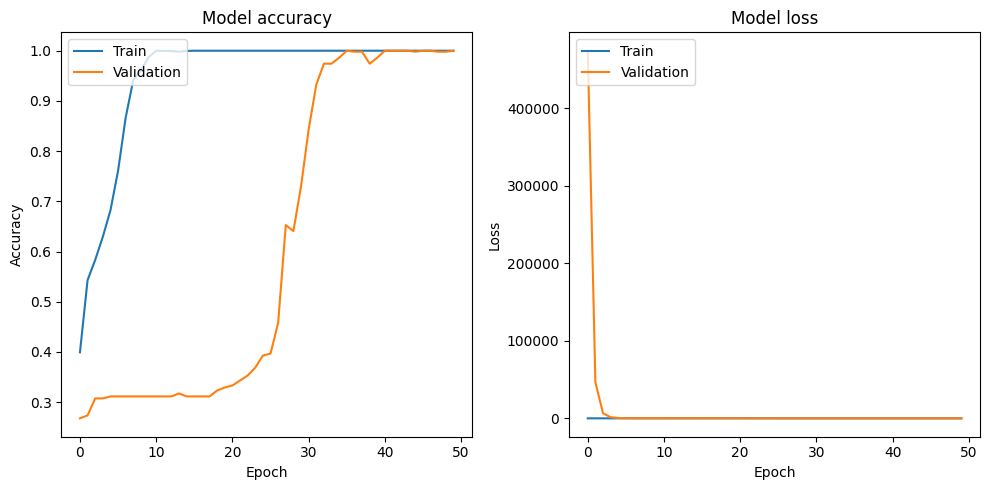

💾 TFLite Model Size: 2736568
TFLite Quantized Model Accuracy: 0.9247
🎯 Test accuracy: 0.9247


In [11]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit()
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

model = tf.keras.models.load_model('supernetwork.keras')

with suppress_output():
    tflite_model, interpreter = convert_to_tflite(model)
print(f"💾 TFLite Model Size:", len(tflite_model))

# Evaluate the quantized model on the test_ds
test_acc = evaluate_tflite_model(interpreter, test_ds)

print(f"🎯 Test accuracy: {test_acc:.4f}")

In [13]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Before TFLITE Test accuracy: {test_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9223 - loss: 0.4637
Before TFLITE Test accuracy: 0.9247


## 🦠 Generate Population of Sub-network and Evolution Search

In [ ]:
# run evolution for the entire state space (WILL TAKE A LONG TIME!)

model = tf.keras.models.load_model('supernetwork.keras')
POP_ITERATIONS = 2

for i in range(POP_ITERATIONS):
    print(f"🧬 Generation {i+1}/{POP_ITERATIONS}")

    # Initialize the Population
    population = []

    if i == 0:
        with tqdm(total=POP_SIZE, desc="Initial Population") as pbar:
            while len(population) < POP_SIZE:
                config = {
                    'starting_kernel': random.choice(KERNEL),
                    'depth_0': random.choice(DEPTH),
                    'depth_1': random.choice(DEPTH),
                    'kernel_0': random.choice(KERNEL),
                    'kernel_1': random.choice(KERNEL),
                }

                subnetwork = sample_subnetwork(model, config, resolution=RESOLUTION, width=WIDTH, num_classes=NUM_CLASSES)

                with suppress_output():
                    tflite_model, interpreter = convert_to_tflite(model)
                flash_size = len(tflite_model)

                if flash_size < (1e6/2):
                    calibrate_batchnorm(subnetwork, val_ds, num_batches=128)
                    # evaluate on val_ds
                    subnetwork.compile(
                        optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy']
                    )
                    history = subnetwork.fit(val_ds, epochs=2, verbose=0)
                    fitness = history.history['accuracy'][-1]
                    population.append((config, fitness))
                    print(f"🦠 Initial population: ")
                    for cfg, fitness in population:
                        print(f"    Config: {cfg}, Fitness: {fitness}")
    else:
        population = evolve_one_generation(population, search_space)
        print(f"🦠 New population: ")
        for cfg, fitness in population:
            print(f"    Config: {cfg}, Fitness: {fitness}")
        print(f"💪 Best fitness: {max(population, key=lambda x: x[1])}")

🧬 Generation 1/2


We manually run the genetic algorithm for now to prevent crashes. If you wish to iterate over the entire resolution, all you need to do is run the code above

### 🌎 **Population 1 (Initial Random Population)**

In [6]:
model = tf.keras.models.load_model('supernetwork.keras')
print(f"🧬 Generation {1}/{POP_ITERATIONS}")
population = []

while len(population) < POP_SIZE:
    config = {
        'starting_kernel': random.choice(KERNEL),
        'depth_0': random.choice(DEPTH),
        'depth_1': random.choice(DEPTH),
        'kernel_0': random.choice(KERNEL),
        'kernel_1': random.choice(KERNEL),
    }

    subnetwork = sample_subnetwork(model, config, resolution=RESOLUTION, width=WIDTH, num_classes=NUM_CLASSES)

    with suppress_output():
        tflite_model, interpreter = convert_to_tflite(subnetwork)
    flash_size = len(tflite_model)

    if flash_size < (1e6/2):
        calibrate_batchnorm(subnetwork, val_ds, num_batches=128)
        # evaluate on val_ds
        subnetwork.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        history = subnetwork.fit(val_ds, epochs=5, verbose=0)
        fitness = history.history['accuracy'][-1]
        print(f"🦠 Added to population: ")
        print(f"    Config: {config}, Fitness: {fitness}")
        population.append((config, fitness))
print(f"🦠 Initial population: ")
for cfg, fitness in population:
    print(f"    Config: {cfg}, Fitness: {fitness}")

🧬 Generation 1/10
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 5, 'depth_0': 3, 'depth_1': 4, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.6646825671195984
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 3, 'depth_0': 3, 'depth_1': 3, 'kernel_0': 3, 'kernel_1': 5}, Fitness: 0.7202380895614624
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 5}, Fitness: 0.8115079402923584
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 3, 'depth_0': 3, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 3}, Fitness: 0.9305555820465088
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 5, 'depth_0': 4, 'depth_1': 1, 'kernel_0': 3, 'kernel_1': 7}, Fitness: 0.9464285969734192
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 1, 'kernel_0': 9, 'kernel_1': 3}, Fitness: 0.928

### 🌎 **Population 2 (Evolution Algo)**

In [7]:
print(f"🧬 Generation {2}/{POP_ITERATIONS}")
population = evolve_one_generation(population, search_space, model, val_ds)
print(f"🦠 New population: ")
for cfg, fitness in population:
    print(f"    Config: {cfg}, Fitness: {fitness}")
print(f"💪 Best fitness: {max(population, key=lambda x: x[1])}")

🧬 Generation 2/10
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 3, 'depth_0': 1, 'depth_1': 1, 'kernel_0': 5, 'kernel_1': 7}, Fitness: 0.8015872836112976
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 3, 'depth_0': 1, 'depth_1': 1, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.8472222089767456
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 3, 'depth_0': 1, 'depth_1': 1, 'kernel_0': 3, 'kernel_1': 7}, Fitness: 0.8908730149269104
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 5, 'depth_0': 4, 'depth_1': 1, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.8928571343421936
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 5, 'depth_0': 4, 'depth_1': 1, 'kernel_0': 3, 'kernel_1': 7}, Fitness: 0.8769841194152832
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 3}, Fitness: 0.946

### 🌎 **Population 3 (Evolution Algo)**

In [8]:
print(f"🧬 Generation {3}/{POP_ITERATIONS}")
population = evolve_one_generation(population, search_space, model, val_ds)
print(f"🦠 New population: ")
for cfg, fitness in population:
    print(f"    Config: {cfg}, Fitness: {fitness}")
print(f"💪 Best fitness: {max(population, key=lambda x: x[1])}")

🧬 Generation 3/10
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 1, 'depth_1': 1, 'kernel_0': 5, 'kernel_1': 5}, Fitness: 0.8591269850730896
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 2, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 3}, Fitness: 0.8353174328804016
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 5}, Fitness: 0.9027777910232544
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 1, 'depth_1': 1, 'kernel_0': 5, 'kernel_1': 5}, Fitness: 0.8373016119003296
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 2, 'depth_1': 1, 'kernel_0': 5, 'kernel_1': 5}, Fitness: 0.9821428656578064
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.910

### 🌎 **Population 4 (Evolution Algo)**

In [9]:
print(f"🧬 Generation {4}/{POP_ITERATIONS}")
population = evolve_one_generation(population, search_space, model, val_ds)
print(f"🦠 New population: ")
for cfg, fitness in population:
    print(f"    Config: {cfg}, Fitness: {fitness}")
print(f"💪 Best fitness: {max(population, key=lambda x: x[1])}")

🧬 Generation 4/10
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 2, 'depth_1': 1, 'kernel_0': 5, 'kernel_1': 3}, Fitness: 0.8253968358039856
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 2, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 3}, Fitness: 0.682539701461792
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 2, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 5}, Fitness: 0.988095223903656
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 2, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 3}, Fitness: 0.932539701461792
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 1, 'kernel_0': 7, 'kernel_1': 3}, Fitness: 0.7757936716079712
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 7, 'kernel_1': 3}, Fitness: 0.940476

### 🌎 **Population 5 (Evolution Algo)**

In [10]:
print(f"🧬 Generation {5}/{POP_ITERATIONS}")
population = evolve_one_generation(population, search_space, model, val_ds)
print(f"🦠 New population: ")
for cfg, fitness in population:
    print(f"    Config: {cfg}, Fitness: {fitness}")
print(f"💪 Best fitness: {max(population, key=lambda x: x[1])}")

🧬 Generation 5/10
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 2, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 5}, Fitness: 0.886904776096344
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 2, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 3}, Fitness: 0.9265872836112976
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 7, 'kernel_1': 3}, Fitness: 0.9444444179534912
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 5}, Fitness: 0.9801587462425232
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 5}, Fitness: 0.6388888955116272
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 1, 'depth_1': 4, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.9722

### 🌎 **Population 6 (Evolution Algo)**

In [11]:
print(f"🧬 Generation {6}/{POP_ITERATIONS}")
population = evolve_one_generation(population, search_space, model, val_ds)
print(f"🦠 New population: ")
for cfg, fitness in population:
    print(f"    Config: {cfg}, Fitness: {fitness}")
print(f"💪 Best fitness: {max(population, key=lambda x: x[1])}")

🧬 Generation 6/10
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 5}, Fitness: 0.8730158805847168
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 7, 'kernel_1': 3}, Fitness: 0.9047619104385376
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 3}, Fitness: 0.9305555820465088
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 5}, Fitness: 0.8928571343421936
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 7, 'kernel_1': 3}, Fitness: 0.9107142686843872
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 3}, Fitness: 0.972

### 🌎 **Population 7 (Evolution Algo)**

In [12]:
print(f"🧬 Generation {7}/{POP_ITERATIONS}")
population = evolve_one_generation(population, search_space, model, val_ds)
print(f"🦠 New population: ")
for cfg, fitness in population:
    print(f"    Config: {cfg}, Fitness: {fitness}")
print(f"💪 Best fitness: {max(population, key=lambda x: x[1])}")

🧬 Generation 7/10
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 3}, Fitness: 0.9384920597076416
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.8809523582458496
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.8591269850730896
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.9484127163887024
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 7, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 3}, Fitness: 0.9126983880996704
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 2, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 5}, Fitness: 0.759

### 🌎 **Population 8 (Evolution Algo)**

In [13]:
print(f"🧬 Generation {8}/{POP_ITERATIONS}")
population = evolve_one_generation(population, search_space, model, val_ds)
print(f"🦠 New population: ")
for cfg, fitness in population:
    print(f"    Config: {cfg}, Fitness: {fitness}")
print(f"💪 Best fitness: {max(population, key=lambda x: x[1])}")

🧬 Generation 8/10
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.9067460298538208
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 3}, Fitness: 0.7916666865348816
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.9384920597076416
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.807539701461792
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.8690476417541504
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 5, 'depth_0': 1, 'depth_1': 3, 'kernel_0': 5, 'kernel_1': 3}, Fitness: 0.9404

### 🌎 **Population 9 (Evolution Algo)**

In [14]:
print(f"🧬 Generation {9}/{POP_ITERATIONS}")
population = evolve_one_generation(population, search_space, model, val_ds)
print(f"🦠 New population: ")
for cfg, fitness in population:
    print(f"    Config: {cfg}, Fitness: {fitness}")
print(f"💪 Best fitness: {max(population, key=lambda x: x[1])}")

🧬 Generation 9/10
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 5}, Fitness: 0.9305555820465088
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.9246031641960144
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 3}, Fitness: 0.9265872836112976
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 5, 'kernel_1': 5}, Fitness: 0.7817460298538208
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 5}, Fitness: 0.8829365372657776
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.873

### 🌎 **Population 10 (Evolution Algo)**

In [15]:
print(f"🧬 Generation {10}/{POP_ITERATIONS}")
population = evolve_one_generation(population, search_space, model, val_ds)
print(f"🦠 New population: ")
for cfg, fitness in population:
    print(f"    Config: {cfg}, Fitness: {fitness}")
print(f"💪 Best fitness: {max(population, key=lambda x: x[1])}")

🧬 Generation 10/10
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 3, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.9047619104385376
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 5}, Fitness: 0.8115079402923584
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 5}, Fitness: 0.9484127163887024
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 1, 'depth_1': 4, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.9583333134651184
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 3, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 5}, Fitness: 0.966269850730896
✅ Calibration done.
🦠 Added to population: 
    Config: {'starting_kernel': 9, 'depth_0': 3, 'depth_1': 2, 'kernel_0': 3, 'kernel_1': 3}, Fitness: 0.948

# 📌 Summary

## NAS Result:

The best performing model in resolution 128 and width 64: <br>
💪 Best fitness: {'starting_kernel': 7,
'depth_0': 2,
'depth_1': 2,
'kernel_0': 5,
'kernel_1': 5
} <br>
Fitness: 0.988095223903656 <br>
🌎 From Generation 4

# 📝 Final fine-tuning and Evaluation

## Description:
In this final phase, we perform a targeted fine-tuning of the best architecture found during the neural architecture search (NAS). This step leverages the full training dataset to refine model weights for optimal accuracy and generalization. After fine-tuning, the model is quantized and converted to the TFLite format for deployment. We then evaluate the quantized model's performance on the test set, measuring both classification accuracy and real-world inference latency. This step ensures the selected model meets both accuracy and efficiency requirements for deployment on resource-constrained hardware.

In [19]:
config = {
    'starting_kernel': 7,
    'depth_0': 2,
    'depth_1': 2,
    'kernel_0': 5,
    'kernel_1': 5
}
model = tf.keras.models.load_model('supernetwork.keras')
subnetwork = sample_subnetwork(model, config, resolution=RESOLUTION, width=WIDTH, num_classes=NUM_CLASSES)
final_train_dataset = train_ds.concatenate(val_ds)
subnetwork.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = subnetwork.fit(final_train_dataset, epochs=50, validation_data=test_ds)
subnetwork.save('best_model.keras')

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 312ms/step - accuracy: 0.5191 - loss: 2.0029 - val_accuracy: 0.3333 - val_loss: 971.6285
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9736 - loss: 0.0957 - val_accuracy: 0.3333 - val_loss: 892.6024
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.3333 - val_loss: 512.9510
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.3333 - val_loss: 325.6208
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.3333 - val_loss: 195.1436
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.3333 - val_loss: 146.0061
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 7.2298e-04 - val_accuracy: 0.3333 - val_loss: 118.5933
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 5.3764e-04 - 

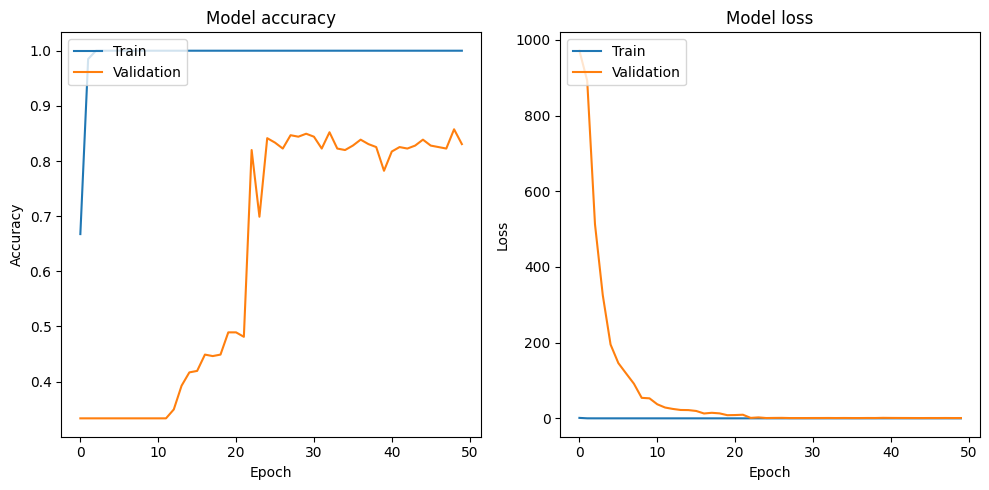

Model: "sequential_177"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv0 (Conv2D)                  │ (None, 128, 128, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 128, 128, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act0 (ReLU)                     │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool0 (MaxPooling2D)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block0_conv0 (Conv2D)           │ (None, 64, 64, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_731         │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_731 (ReLU)                │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block0_conv1 (Conv2D)           │ (None, 64, 64, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_732         │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_732 (ReLU)                │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_354               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv0 (Conv2D)           │ (None, 32, 32, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_733         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_733 (ReLU)                │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_734         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_734 (ReLU)                │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_355               │ (None, 16, 16, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │        49,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,408,011 (5.37 MB)

 Trainable params: 469,123 (1.79 MB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 938,248 (3.58 MB)

💾 TFLite Model Size: 479184
TFLite Quantized Model Accuracy: 0.8306
🎯 Test accuracy: 0.8306


In [20]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit()
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

model = tf.keras.models.load_model('best_model.keras')
model.summary()

with suppress_output():
    tflite_model, interpreter = convert_to_tflite(model)
print(f"💾 TFLite Model Size:", len(tflite_model))

# Evaluate the quantized model on the test_ds
test_acc = evaluate_tflite_model(interpreter, test_ds)

print(f"🎯 Test accuracy: {test_acc:.4f}")

## ⏳ Timing Analysis

In [23]:
import time

def evaluate_tflite_model(interpreter, test_ds):
    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_index = input_details[0]['index']
    output_index = output_details[0]['index']

    correct = 0
    total = 0
    inference_times = []

    for x_batch, y_batch in test_ds:
        x_batch_np = x_batch.numpy()
        y_true = tf.argmax(y_batch, axis=1).numpy()

        for i in range(x_batch_np.shape[0]):
            input_tensor = np.expand_dims(x_batch_np[i], axis=0).astype(input_details[0]['dtype'])
            interpreter.set_tensor(input_index, input_tensor)

            # Time measurement starts here
            start_time = time.time()
            interpreter.invoke()
            end_time = time.time()
            # Time per inference in milliseconds
            inference_times.append((end_time - start_time) * 1000)

            output = interpreter.get_tensor(output_index)
            y_pred = np.argmax(output)

            if y_pred == y_true[i]:
                correct += 1
            total += 1

    accuracy = correct / total
    avg_inference_time = sum(inference_times) / len(inference_times)

    print(f"TFLite Quantized Model Accuracy: {accuracy:.4f}")
    print(f"Average Inference Time (ms/sample): {avg_inference_time:.4f}")

    return accuracy, avg_inference_time

In [28]:
supernetwork = tf.keras.models.load_model('supernetwork.keras')
best_model = tf.keras.models.load_model('best_model.keras')

with suppress_output():
    tflite_model, interpreter = convert_to_tflite(supernetwork)
supernetwork_accuracy, supernetwork_time = evaluate_tflite_model(interpreter, test_ds)
print(f"Supernetwork flash size: {len(tflite_model)}")

with suppress_output():
    tflite_model, interpreter = convert_to_tflite(best_model)
best_model_accuracy, best_model_time = evaluate_tflite_model(interpreter, test_ds)
print(f"Best model flash size: {len(tflite_model)}")

TFLite Quantized Model Accuracy: 0.9247
Average Inference Time (ms/sample): 47.8485
Supernetwork flash size: 2736568
TFLite Quantized Model Accuracy: 0.8306
Average Inference Time (ms/sample): 10.9453
Best model flash size: 479184


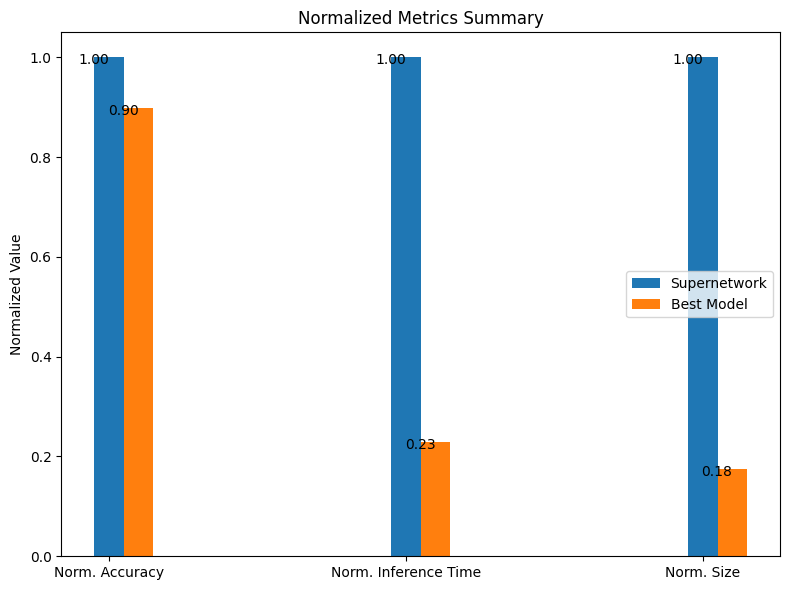

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Example data from your outputs
accuracies = [0.9247, 0.8306]
times = [47.8485, 10.9453]
flash_sizes = [2736568, 479184]

# Normalize data (scale to 0–1)
acc_norm = [a / max(accuracies) for a in accuracies]
time_norm = [t / max(times) for t in times]
flash_norm = [f / max(flash_sizes) for f in flash_sizes]

supernetwork = [acc_norm[0], time_norm[0], flash_norm[0]]
best_model = [acc_norm[1], time_norm[1], flash_norm[1]]

labels = ['Norm. Accuracy', 'Norm. Inference Time', 'Norm. Size']
x = np.arange(len(labels))  # label locations
width = 0.10  # bar width

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x, supernetwork, width, label='Supernetwork')
bars2 = ax.bar(x + width, best_model, width, label='Best Model')

# Labels & title
ax.set_ylabel('Normalized Value')
ax.set_title('Normalized Metrics Summary')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally annotate bars
def annotate_bars(bars, values):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.annotate(f'{value:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='right', va='top')

annotate_bars(bars1, supernetwork)
annotate_bars(bars2, best_model)

plt.tight_layout()
plt.show()